## Outline

- preprocessing: missing values etc
- train-validation-test split
    - don't need validation split for random forest. use OOB error
- scale after split to prevent data leakage
- random forest hyperparameter tuning
- fit final random forest

## Libraries

In [122]:
import pandas as pd
import numpy as np
import time

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# evalutation
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform, loguniform

# visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image


## Import data

In [38]:
raw_data = pd.read_csv("../data/breastCancer.csv", delimiter="\t",
                       na_values="?", header=0)

In [39]:
raw_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,gender,Bratio
0,842302.0,M,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.1471,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,F,0.162878
1,84300903.0,M,19.69,21.25,130.00,1203.0,0.10960,0.1599,0.1974,0.1279,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,F,0.751106
2,84348301.0,M,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.1052,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,F,0.465537
3,84358402.0,M,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.1043,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,F,0.969993
4,844359.0,M,18.25,-19.98,119.60,1040.0,0.09463,0.1090,0.1127,0.0740,...,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,F,0.552544


In [40]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       563 non-null    float64
 1   diagnosis                569 non-null    object 
 2   radius_mean              563 non-null    float64
 3   texture_mean             564 non-null    float64
 4   perimeter_mean           567 non-null    float64
 5   area_mean                563 non-null    float64
 6   smoothness_mean          567 non-null    float64
 7   compactness_mean         565 non-null    float64
 8   concavity_mean           562 non-null    float64
 9   concave points_mean      567 non-null    float64
 10  symmetry_mean            563 non-null    float64
 11  fractal_dimension_mean   567 non-null    float64
 12  radius_se                566 non-null    float64
 13  texture_se               566 non-null    float64
 14  perimeter_se             5

## Preprocessing

In [41]:
# sklearn implementation requires all features to be numreric
raw_data['diagnosis'] = raw_data['diagnosis'].map({"M":1, "B":0})

# remove constant and unique column
raw_data = raw_data.drop(columns = ["id", "gender"])

In [82]:
# train-test split
# the training data is used for training and hyperparameter selection via OOB error
# final model is evaluated on the test set
X = raw_data.drop(columns=["diagnosis"])
y = raw_data["diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random forest

Tuning parameters: number of trees and number of features randomly selected at each split

[Tutorial](https://www.datacamp.com/tutorial/random-forests-classifier-python)

In [125]:
np.random.seed(42)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# can handle missing values
# m = sqrt(p) by default
rf = RandomForestClassifier(oob_score = True, 
                            bootstrap = True,
                            random_state = 42)

rf_start = time.perf_counter()
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5)

rand_search.fit(X_train, y_train)
rf_elapsed = time.perf_counter() - rf_start
print("Time (RF)", rf_elapsed, "s")

for i, params in enumerate(rand_search.cv_results_['params']):
    print(f"Iteration {i+1}: {params}")

Time (RF) 65.42484705901006 s
Iteration 1: {'max_depth': 7, 'n_estimators': 485}
Iteration 2: {'max_depth': 15, 'n_estimators': 156}
Iteration 3: {'max_depth': 8, 'n_estimators': 238}
Iteration 4: {'max_depth': 7, 'n_estimators': 171}
Iteration 5: {'max_depth': 19, 'n_estimators': 264}
Iteration 6: {'max_depth': 11, 'n_estimators': 137}
Iteration 7: {'max_depth': 4, 'n_estimators': 409}
Iteration 8: {'max_depth': 3, 'n_estimators': 199}
Iteration 9: {'max_depth': 2, 'n_estimators': 393}
Iteration 10: {'max_depth': 12, 'n_estimators': 463}


In [55]:
best_rf = rand_search.best_estimator_
print(best_rf)

RandomForestClassifier(max_depth=7, n_estimators=485, oob_score=True,
                       random_state=42)


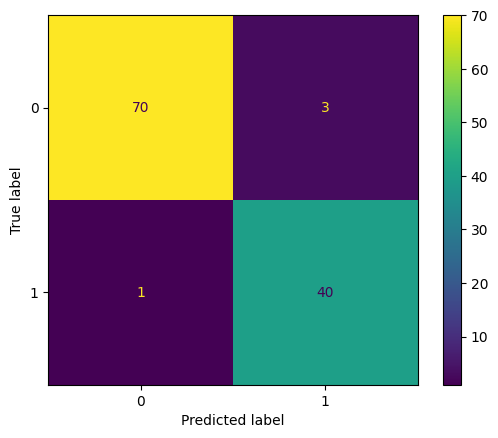

In [56]:
# predictions with the best model
y_pred = best_rf.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [57]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.9649122807017544
Precision: 0.9302325581395349
Recall: 0.975609756097561
F1 Score: 0.9523809523809524


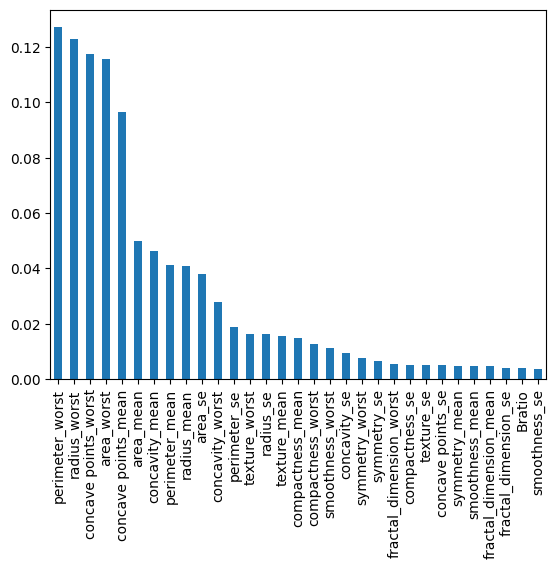

In [58]:
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar();

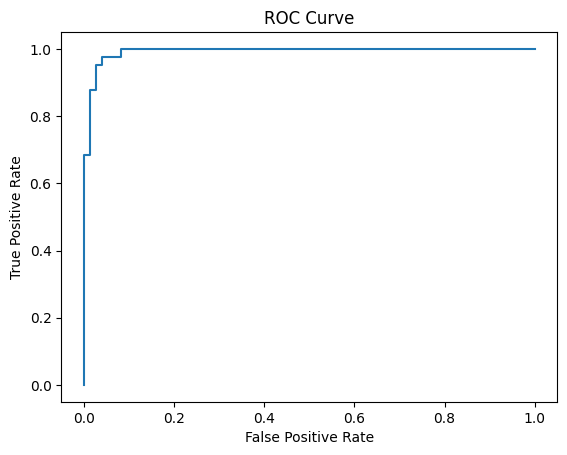

In [ ]:
roc_curve_data = roc_curve(y_test, best_rf.predict_proba(X_test)[:,1])
import matplotlib.pyplot as plt
plt.plot(roc_curve_data[0], roc_curve_data[1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Random Forest")
plt.show()

In [61]:
rf_roc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1])
print("ROC AUC:", rf_roc)

ROC AUC: 0.9923154026060809


## Heterogeneous ensemble

1. Random forest (bagging)

2. AdaBoost (boosting)

3. SVM (non-tree based)

### AdaBoost

"AdaBoost is sensitive to noise data. It is highly affected by outliers because it tries to fit each point perfectly. AdaBoost is slower compared to XGBoost."

[Tutorial](https://www.datacamp.com/tutorial/adaboost-classifier-python)

In [83]:
# use the same train-test split as before
# no validation set necessary; use cross-validation

# preprocessing:
# impute missing values (decision stumps can't deal with those)
# standardise data

adb_X = X_train.copy()
adb_y = y_train.copy()

imputer = SimpleImputer(strategy='mean')
adb_X = imputer.fit_transform(adb_X)
adb_te_X = imputer.transform(X_test)

scaler = StandardScaler()
adb_X = scaler.fit_transform(adb_X)
adb_te_X = scaler.transform(adb_te_X)

In [124]:
np.random.seed(42)
param_dist_adb = {'n_estimators': randint(50, 250),
                  'learning_rate': uniform(0.0, 1.0)}

# use stump as base learner; default in AdaBoostClassifier implementation
adb = AdaBoostClassifier(random_state=42)

abd_start = time.perf_counter()
search_adb = RandomizedSearchCV(adb, 
                                param_distributions = param_dist_adb, 
                                n_iter=10, 
                                cv=5)

search_adb.fit(adb_X, adb_y)
abd_elapsed = time.perf_counter() - abd_start
print("Time (Adaboost):", abd_elapsed, "s")

for i, params in enumerate(search_adb.cv_results_['params']):
    print(f"Iteration {i+1}: {params}")

Time (Adaboost): 34.9967933089938 s
Iteration 1: {'learning_rate': 0.3745401188473625, 'n_estimators': 142}
Iteration 2: {'learning_rate': 0.1834347898661638, 'n_estimators': 121}
Iteration 3: {'learning_rate': 0.5986584841970366, 'n_estimators': 152}
Iteration 4: {'learning_rate': 0.44583275285359114, 'n_estimators': 124}
Iteration 5: {'learning_rate': 0.45924889196586716, 'n_estimators': 166}
Iteration 6: {'learning_rate': 0.6011150117432088, 'n_estimators': 201}
Iteration 7: {'learning_rate': 0.6508884729488529, 'n_estimators': 102}
Iteration 8: {'learning_rate': 0.9699098521619943, 'n_estimators': 207}
Iteration 9: {'learning_rate': 0.21233911067827616, 'n_estimators': 241}
Iteration 10: {'learning_rate': 0.9922115592912175, 'n_estimators': 210}


In [85]:
best_adb = search_adb.best_estimator_
print(best_adb)

AdaBoostClassifier(learning_rate=0.1834347898661638, n_estimators=121,
                   random_state=42)


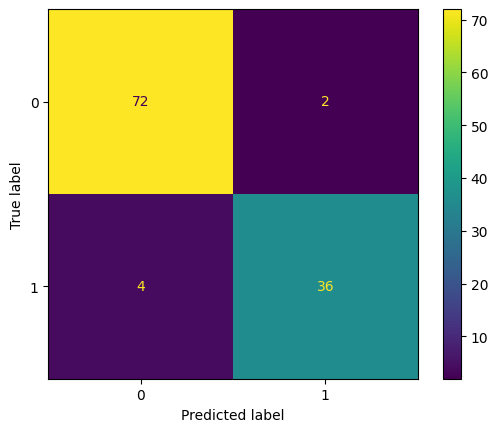

In [86]:
adb_pred = best_adb.predict(adb_te_X)
cm = confusion_matrix(y_test, adb_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

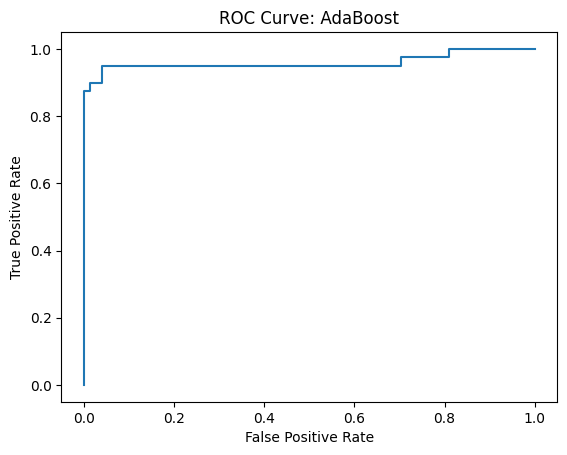

In [87]:
roc_curve_data = roc_curve(y_test, best_adb.predict_proba(adb_te_X)[:,1])
import matplotlib.pyplot as plt
plt.plot(roc_curve_data[0], roc_curve_data[1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: AdaBoost")
plt.show()

In [88]:
rf_roc = roc_auc_score(y_test, best_adb.predict_proba(adb_te_X)[:,1])
print("ROC AUC:", rf_roc)

ROC AUC: 0.9597972972972972


In [89]:
accuracy = accuracy_score(y_test, adb_pred)
precision = precision_score(y_test, adb_pred)
recall = recall_score(y_test, adb_pred)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.9473684210526315
Precision: 0.9473684210526315
Recall: 0.9
F1 Score: 0.9230769230769231


### SVM

In [91]:
# preprocessing the same as for adaboost
# impute missing values and standardise data
svm_X = adb_X.copy()
svm_te_X = adb_te_X.copy()

svm_y = adb_y.copy()

In [ ]:
np.random.seed(42)
param_dist_svm = {
    'C': loguniform(1e-2, 1e3),
    'gamma': loguniform(1e-4, 1e1),
    'kernel': ['rbf']
}

svm = SVC(random_state=42, probability=True)

svm_start = time.perf_counter()
search_svm = RandomizedSearchCV(svm, 
                                param_distributions = param_dist_svm, 
                                n_iter=10, 
                                cv=5)

search_svm.fit(svm_X, svm_y)
svm_elapsed = time.perf_counter() - svm_start
print("Time (SVM):", svm_elapsed, "s")

for i, params in enumerate(search_svm.cv_results_['params']):
    print(f"Iteration {i+1}: {params}")

Iteration 1: {'C': 0.7459343285726545, 'gamma': 5.669849511478847, 'kernel': 'rbf'}
Iteration 2: {'C': 45.70563099801453, 'gamma': 0.09846738873614563, 'kernel': 'rbf'}
Iteration 3: {'C': 0.06026889128682508, 'gamma': 0.000602521573620386, 'kernel': 'rbf'}
Iteration 4: {'C': 0.0195172246414495, 'gamma': 2.1423021757741068, 'kernel': 'rbf'}
Iteration 5: {'C': 10.129197956845726, 'gamma': 0.3470266988650412, 'kernel': 'rbf'}
Iteration 6: {'C': 0.012674255898937233, 'gamma': 7.072114131472227, 'kernel': 'rbf'}
Iteration 7: {'C': 145.28246637516014, 'gamma': 0.0011526449540315614, 'kernel': 'rbf'}
Iteration 8: {'C': 0.08111941985431921, 'gamma': 0.0008260808399079611, 'kernel': 'rbf'}
Iteration 9: {'C': 0.3320559103751956, 'gamma': 0.042051564509138675, 'kernel': 'rbf'}
Iteration 10: {'C': 1.4445251022763053, 'gamma': 0.0028585493941961923, 'kernel': 'rbf'}


In [109]:
best_svm = search_svm.best_estimator_
print(best_svm)

SVC(C=145.28246637516014, gamma=0.0011526449540315614, probability=True,
    random_state=42)


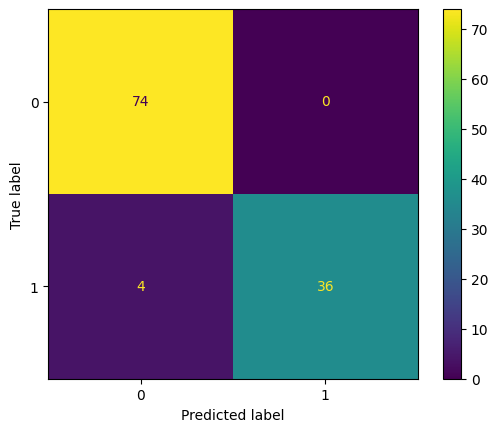

In [110]:
svm_pred = best_svm.predict(svm_te_X)
cm = confusion_matrix(y_test, svm_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

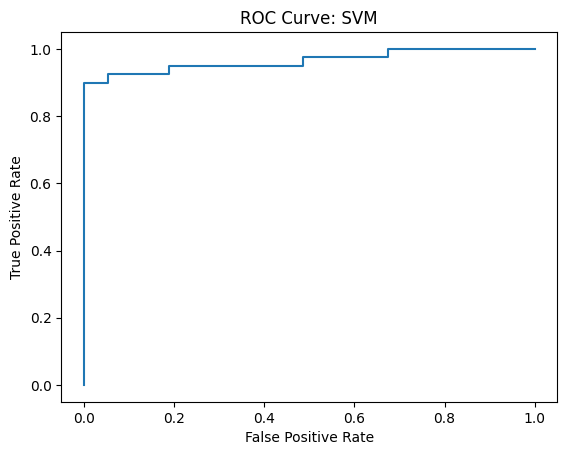

In [111]:
roc_curve_data = roc_curve(y_test, best_svm.predict_proba(svm_te_X)[:,1])
import matplotlib.pyplot as plt
plt.plot(roc_curve_data[0], roc_curve_data[1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: SVM")
plt.show()

In [112]:
rf_roc = roc_auc_score(y_test, best_svm.predict_proba(svm_te_X)[:,1])
print("ROC AUC:", rf_roc)

ROC AUC: 0.9648648648648648


In [113]:
accuracy = accuracy_score(y_test, svm_pred)
precision = precision_score(y_test, svm_pred)
recall = recall_score(y_test, svm_pred)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.9649122807017544
Precision: 1.0
Recall: 0.9
F1 Score: 0.9473684210526316


### Combine components

In [ ]:
estimators = [
    ('rf', best_rf),
    ('svm', best_svm),
    ('adb', best_adb)
]

stack = VotingClassifier(
    estimators=estimators,
    voting='soft'
)

# fit on data approporiately preprocessed
stack.fit(adb_X, adb_y)
y_het_pr = stack.predict(adb_te_X)

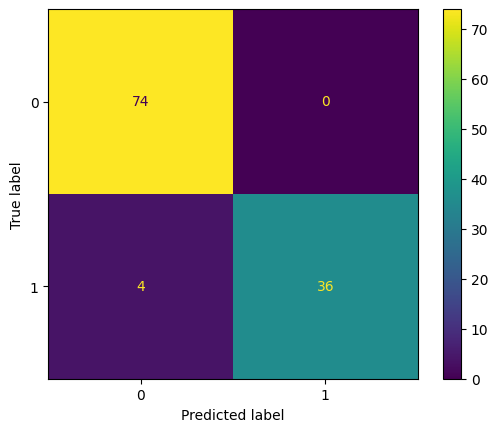

In [121]:
cm = confusion_matrix(y_test, y_het_pr)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

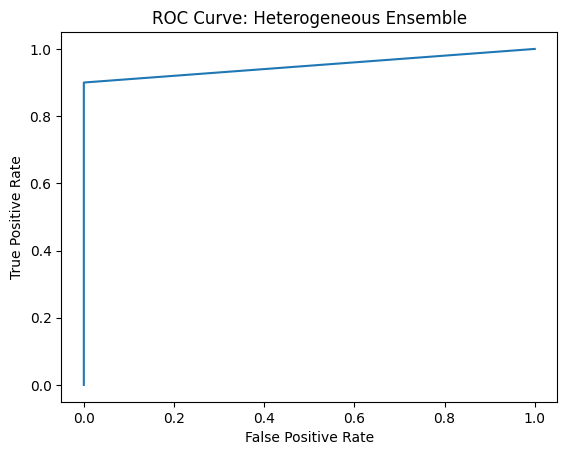

In [117]:
roc_curve_data = roc_curve(y_test, y_het_pr)
import matplotlib.pyplot as plt
plt.plot(roc_curve_data[0], roc_curve_data[1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Heterogeneous Ensemble")
plt.show()

In [118]:
rf_roc = roc_auc_score(y_test, y_het_pr)
print("ROC AUC:", rf_roc)

ROC AUC: 0.95


In [120]:
accuracy = accuracy_score(y_test, y_het_pr)
precision = precision_score(y_test, y_het_pr)
recall = recall_score(y_test, y_het_pr)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.9649122807017544
Precision: 1.0
Recall: 0.9
F1 Score: 0.9473684210526316
